In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten


from keras.metrics import categorical_accuracy

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [ ]:
# Importing the data

# The dataset can be downloaded from this link

import os,cv2
directory='/content/drive/MyDrive/Colab Notebooks/Q1_TrainingData'
dir_list= os.listdir(directory)
image_data_list=[]
labels=[]
emotions=[]
l=0
for data_dir in dir_list:
    data_list=os.listdir(directory+'/'+data_dir)
    for img in data_list:
        input_img=cv2.imread(directory+'/'+data_dir+'/'+img)
        input_img=cv2.resize(input_img,(64,64))
        image_data_list.append(input_img)
        labels.append(l)
    emotions.append(data_dir)
    l=l+1
img_data=np.array(image_data_list)
img_data=img_data/255
img_data.shape

(1262, 64, 64, 3)

In [ ]:
# Analyzing the dataset

# Distribution of classes

for i in range(7):
    print('No of instances with class value '+ str(i) + ' : ' + str(labels.count(i)))

No of instances with class value 0 : 411
No of instances with class value 1 : 433
No of instances with class value 2 : 401
No of instances with class value 3 : 17
No of instances with class value 4 : 0
No of instances with class value 5 : 0
No of instances with class value 6 : 0


In [ ]:
# Train-Validation-Test Split (80-20)

num_classes=4
Y = keras.utils.to_categorical(labels, num_classes)
X_train, X_t, y_train, y_t = train_test_split(img_data, Y, test_size=0.2,shuffle= True, random_state=20)

In [ ]:
import cv2
import numpy as np

def face_preprocessing(img_data):
    # Convert to grayscale for histogram equalization if img is RGB
    if img.shape[-1] == 3:  # Check if image has 3 channels (RGB)
        # Convert to LAB color space
        lab = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2LAB)

        # Split the LAB image into L, A, and B channels
        l, a, b = cv2.split(lab)

        # Apply CLAHE to the L channel
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        cl = clahe.apply(l)

        # Merge the CLAHE-enhanced L channel with original A and B channels
        enhanced_lab = cv2.merge((cl, a, b))

        # Convert back to RGB color space
        enhanced_img = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2RGB)

        return enhanced_img
    else:
        # For grayscale images
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        return clahe.apply(img)

# Now use this function in your ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize pixel values
    preprocessing_function=face_preprocessing,
    rotation_range=10,         # Reduced to ±10° (preserve facial orientation)
    width_shift_range=0.1,     # Reduced to 10% shifts
    height_shift_range=0.1,    # Reduced to 10% shifts
    shear_range=0.05,          # Minimal shear to avoid distortion
    zoom_range=0.1,            # Slight zoom (±10%)
    horizontal_flip=False,     # Usually better to disable for facial recognition
    brightness_range=[0.9, 1.1], # Optional: Adjust lighting subtly
    channel_shift_range=10.0,  # Subtle color variations
    fill_mode='reflect'        # Better for natural edges than 'nearest'
)
datagen.fit(X_train)

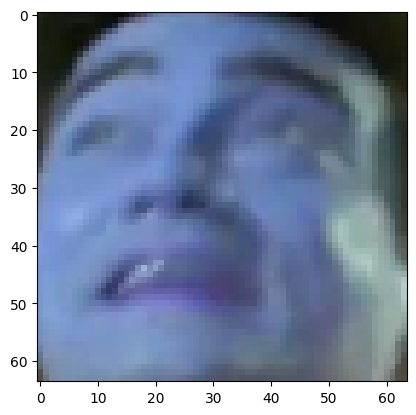

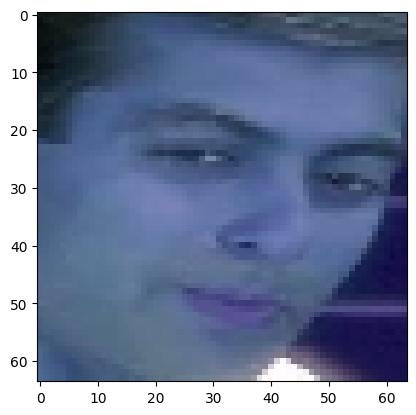

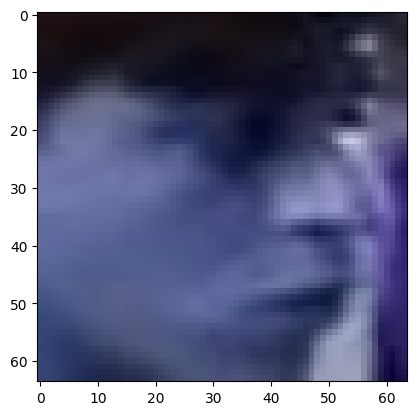

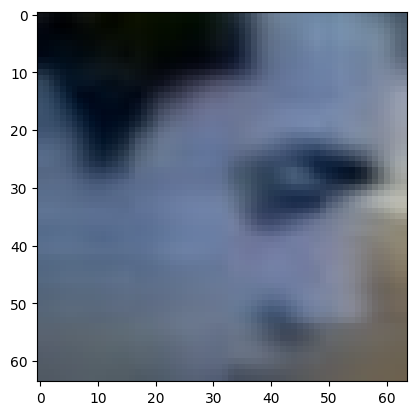

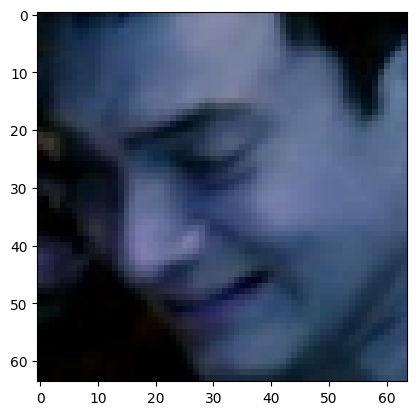

In [ ]:
# Visualising the dataset

import matplotlib.pyplot as plt
for i in range(5):
    plt.imshow(X_train[i])
    plt.show()

In [ ]:
# Fine Tuning VGG19
# Importing the model

from keras.applications import VGG19
vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

In [ ]:
# Freezing the initial layers

for layer in vgg_model.layers[:15]:
    layer.trainable = False

In [ ]:
from tensorflow.keras.regularizers import l1, l2, l1_l2

# Adding dense layers with regularization
x = vgg_model.output
x = Flatten()(x)  # Flatten dimensions for use in FC layers

# L2 regularization (Ridge)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)  # Dropout layer to reduce overfitting

# L1 regularization (Lasso)
x = Dense(256, activation='relu', kernel_regularizer=l1(0.001))(x)
x = Dropout(0.5)(x)  # Additional dropout layer

# L1L2 regularization (ElasticNet)
x = Dense(num_classes, activation='softmax',
          kernel_regularizer=l1_l2(l1=0.001, l2=0.001))(x)  # Softmax for multiclass classification

# Create the transfer model
transfer_model = keras.models.Model(inputs=vgg_model.input, outputs=x)

In [ ]:
# Model Summary

transfer_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,205,828 (80.89 MB)

 Trainable params: 12,980,484 (49.52 MB)

 Non-trainable params: 8,225,344 (31.38 MB)

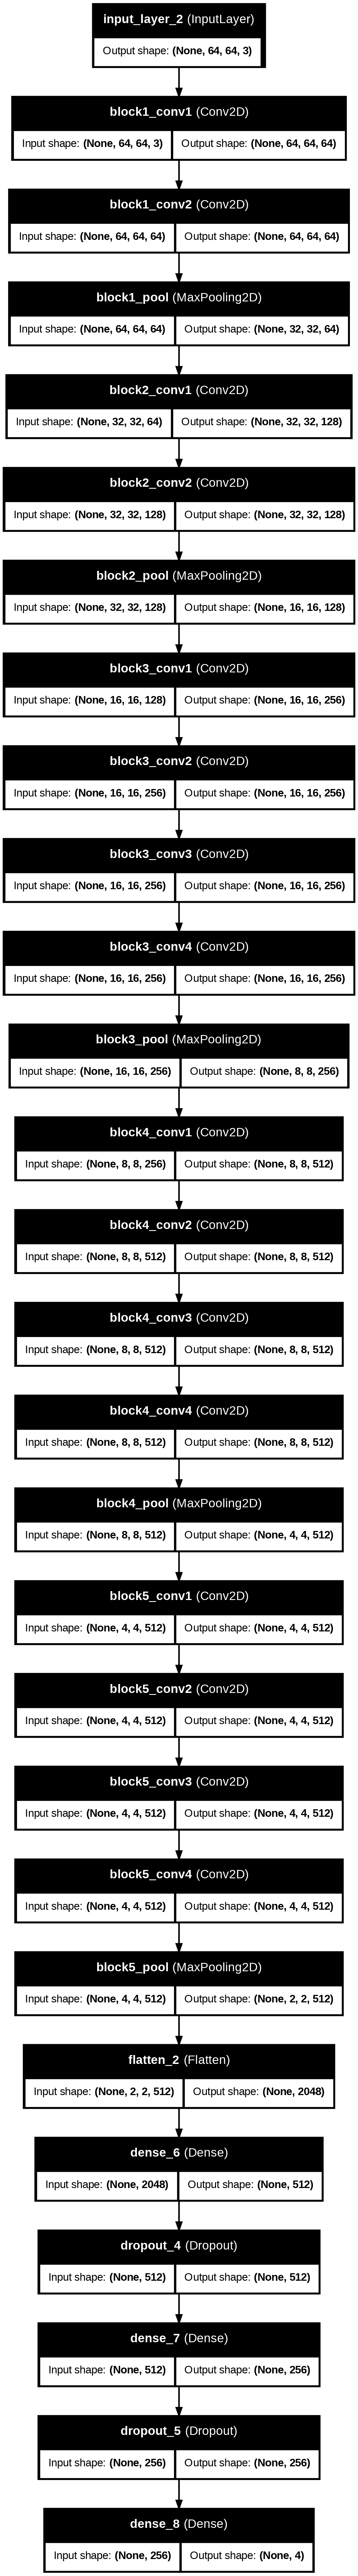

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(transfer_model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

In [ ]:
transfer_model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy", "Precision", "Recall"])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Train-Validation-Test Split (80-20)
num_classes = 4
Y = keras.utils.to_categorical(labels, num_classes)
X_train, X_t, y_train, y_t = train_test_split(img_data, Y, test_size=0.2, shuffle=True, random_state=20)

# Splitting the testing data into validation and testing data (80-20)
X_val, X_test, y_val, y_test = train_test_split(X_t, y_t, test_size=0.2, random_state=20)


# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',    # Metric to monitor
    patience=5,                # Number of epochs with no improvement after which to stop
    verbose=1,                 # Print messages
    restore_best_weights=True, # Restore the best model weights
    mode='max'                 # We want to maximize accuracy
)

model_checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

# Training the model with early stopping
history = transfer_model.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - Precision: 0.2840 - Recall: 0.1142 - accuracy: 0.2808 - loss: 8.1574
Epoch 1: val_accuracy improved from -inf to 0.45545, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 259ms/step - Precision: 0.2856 - Recall: 0.1148 - accuracy: 0.2822 - loss: 8.1506 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.4554 - val_loss: 7.5362
Epoch 2/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - Precision: 0.4775 - Recall: 0.1683 - accuracy: 0.4173 - loss: 7.5071
Epoch 2: val_accuracy improved from 0.45545 to 0.65347, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - Precision: 0.4811 - Recall: 0.1700 - accuracy: 0.4195 - loss: 7.4997 - val_Precision: 0.7836 - val_Recall: 0.5198 - val_accuracy: 0.6535 - val_loss: 6.9157
Epoch 3/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - Precision: 0.7498 - Recall: 0.5914 - accuracy: 0.7006 - loss: 6.8578
Epoch 3: val_accuracy improved from 0.65347 to 0.78713, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - Precision: 0.7495 - Recall: 0.5927 - accuracy: 0.7007 - loss: 6.8521 - val_Precision: 0.8488 - val_Recall: 0.7228 - val_accuracy: 0.7871 - val_loss: 6.4055
Epoch 4/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - Precision: 0.8224 - Recall: 0.7431 - accuracy: 0.7737 - loss: 6.3946
Epoch 4: val_accuracy improved from 0.78713 to 0.79208, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - Precision: 0.8231 - Recall: 0.7432 - accuracy: 0.7745 - loss: 6.3911 - val_Precision: 0.8148 - val_Recall: 0.7624 - val_accuracy: 0.7921 - val_loss: 6.1609
Epoch 5/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - Precision: 0.9237 - Recall: 0.8620 - accuracy: 0.8857 - loss: 5.9132
Epoch 5: val_accuracy improved from 0.79208 to 0.93564, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - Precision: 0.9231 - Recall: 0.8620 - accuracy: 0.8856 - loss: 5.9100 - val_Precision: 0.9471 - val_Recall: 0.8861 - val_accuracy: 0.9356 - val_loss: 5.6662
Epoch 6/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - Precision: 0.9701 - Recall: 0.9361 - accuracy: 0.9424 - loss: 5.5185
Epoch 6: val_accuracy improved from 0.93564 to 0.94059, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - Precision: 0.9691 - Recall: 0.9360 - accuracy: 0.9423 - loss: 5.5176 - val_Precision: 0.9450 - val_Recall: 0.9356 - val_accuracy: 0.9406 - val_loss: 5.4149
Epoch 7/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - Precision: 0.9644 - Recall: 0.9502 - accuracy: 0.9591 - loss: 5.2691
Epoch 7: val_accuracy did not improve from 0.94059
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - Precision: 0.9647 - Recall: 0.9506 - accuracy: 0.9594 - loss: 5.2658 - val_Precision: 0.9350 - val_Recall: 0.9257 - val_accuracy: 0.9356 - val_loss: 5.2694
Epoch 8/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - Precision: 0.9769 - Recall: 0.9708 - accuracy: 0.9768 - loss: 5.0321
Epoch 8: val_accuracy did not improve from 0.94059
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - Precision: 0.9765 - Recall: 0.9705 - accuracy: 0.9764 - loss: 5.0303 - val_Precision: 0.9303 - val_Recall: 0.9257 - val_accuracy: 0.9257 - val_loss: 5.0469
Epoch 9/100
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - Prec

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

best_model = load_model('best_model.h5')

**Generate Predictions**

In [ ]:
# Get true labels and predictions
y_true = np.argmax(y_test, axis=1)  # Convert one-hot to class indices
y_pred = np.argmax(best_model.predict(X_test), axis=1)
y_probs = best_model.predict(X_test)  # Probability scores

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


**Plot Training History**

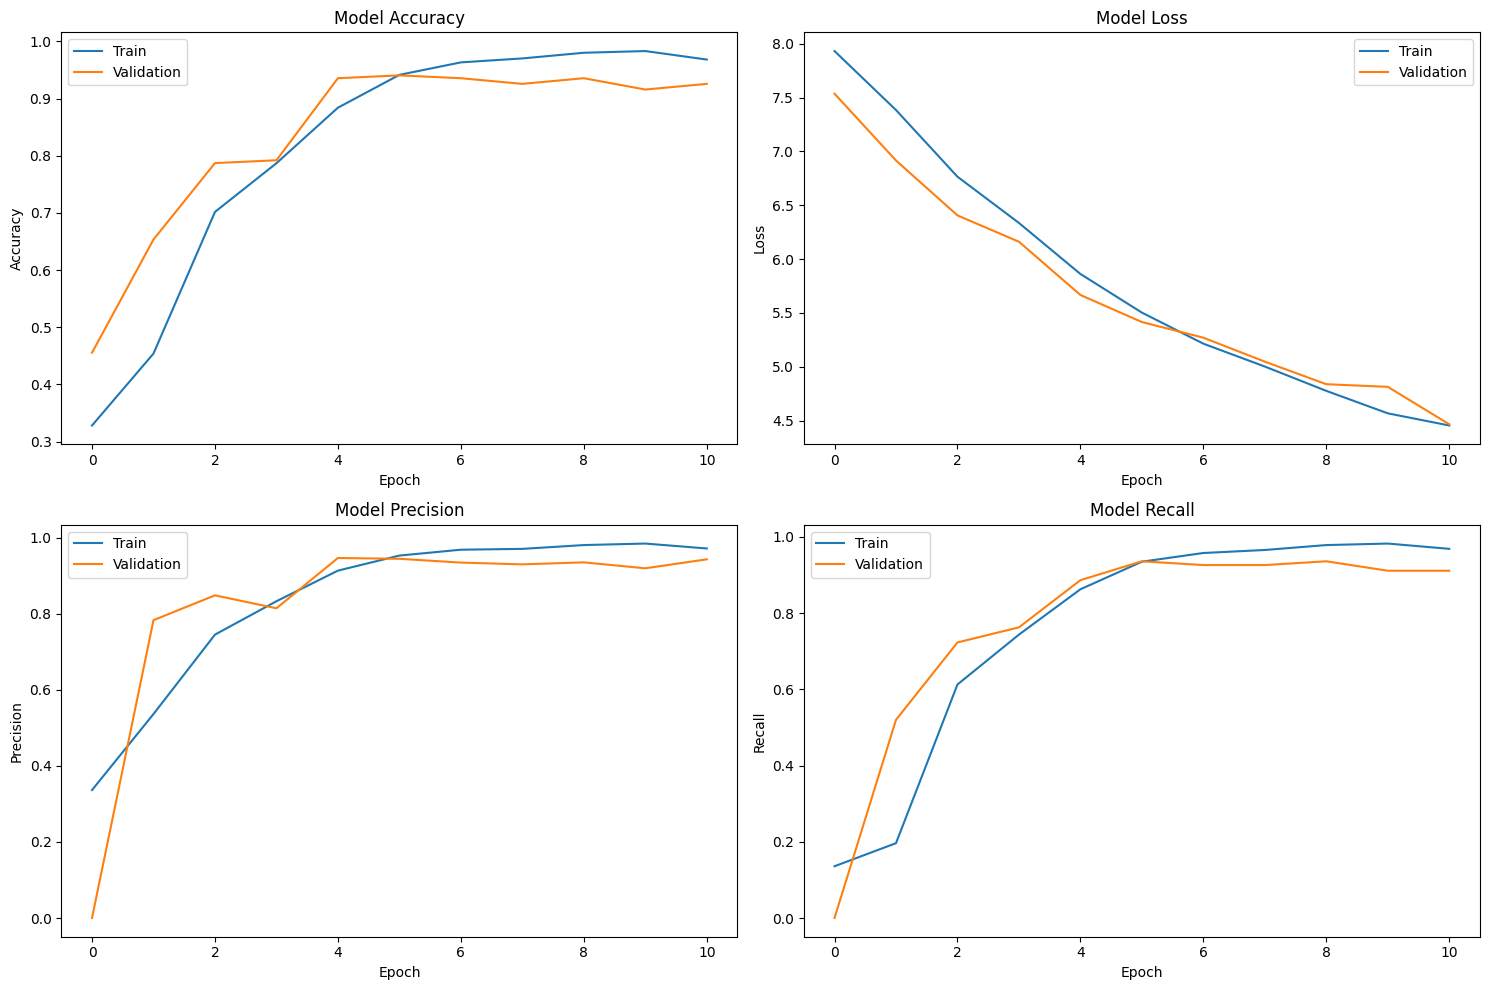

In [ ]:
plt.figure(figsize=(15, 10))

# Accuracy Plot
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss Plot
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Precision Plot
plt.subplot(2, 2, 3)
plt.plot(history.history['Precision'], label='Train')
plt.plot(history.history['val_Precision'], label='Validation')
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend()

# Recall Plot
plt.subplot(2, 2, 4)
plt.plot(history.history['Recall'], label='Train')
plt.plot(history.history['val_Recall'], label='Validation')
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

**Confusion Matrix**

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
Model expects 4 classes
Found 3 classes in y_true/y_pred


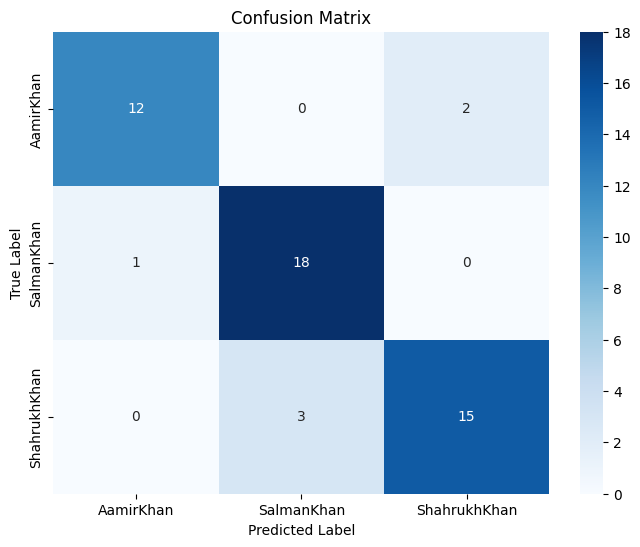


Classification Report:
              precision    recall  f1-score   support

   AamirKhan       0.92      0.86      0.89        14
  SalmanKhan       0.86      0.95      0.90        19
ShahrukhKhan       0.88      0.83      0.86        18

    accuracy                           0.88        51
   macro avg       0.89      0.88      0.88        51
weighted avg       0.88      0.88      0.88        51



In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 1. Load the model
best_model = load_model('best_model.h5')

# 2. Define your class names (REPLACE WITH YOUR ACTUAL CLASSES)
all_class_names = ['AamirKhan', 'SalmanKhan', 'ShahrukhKhan', 'jihed.amor']  # All possible classes

# 3. Generate predictions
y_true = np.argmax(y_test, axis=1)  # Convert one-hot to class indices
y_pred = np.argmax(best_model.predict(X_test), axis=1)

# 4. Check for class mismatches
unique_classes = np.unique(np.concatenate([y_true, y_pred]))
n_classes_model = best_model.output_shape[-1]  # Number of classes the model predicts

print(f"Model expects {n_classes_model} classes")
print(f"Found {len(unique_classes)} classes in y_true/y_pred")

# 5. Adjust class names to match actual predictions
if len(unique_classes) != len(all_class_names):
    print(f"Warning: Expected {len(all_class_names)} classes but found {len(unique_classes)}")
    class_names = [all_class_names[i] for i in unique_classes if i < len(all_class_names)]
else:
    class_names = all_class_names

# 6. Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 7. Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_divisio101
                            n=0))

**Classification Report**

In [ ]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   AamirKhan       0.92      0.86      0.89        14
  SalmanKhan       0.86      0.95      0.90        19
ShahrukhKhan       0.88      0.83      0.86        18

    accuracy                           0.88        51
   macro avg       0.89      0.88      0.88        51
weighted avg       0.88      0.88      0.88        51



In [ ]:
from tensorflow.keras.models import load_model
best_model = load_model('best_model.h5')  # Saved by ModelCheckpoint

In [ ]:
!pip install deepface

In [ ]:
from deepface import DeepFace
import cv2
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from IPython.display import Image
import os


In [ ]:
def capture_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function capturePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({ video: true });

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
        ''')
    display(js)
    data = eval_js('capturePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

**prendre une image pour tester**

<IPython.core.display.Javascript object>

Saved the photo as: photo.jpg


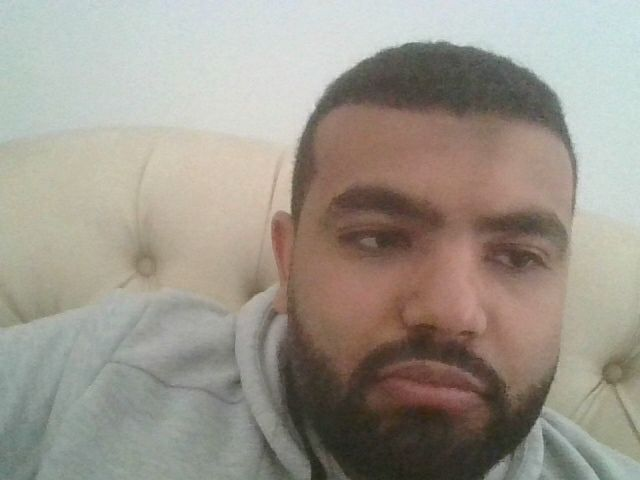

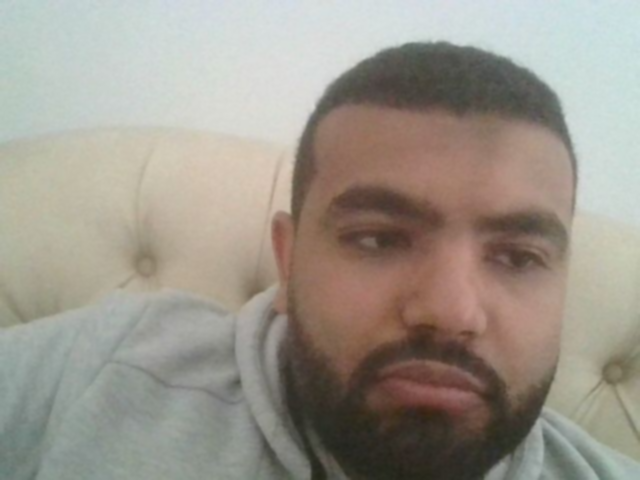

In [ ]:
try:
    new_photo = capture_photo()
    print(f'Saved the photo as: {new_photo}')
    display(Image(new_photo))
except Exception as error:
    print(str(error))

test_image_path = 'photo.jpg'
test_image = cv2.imread(test_image_path)

# Appliquer un filtre gaussien à l'image de test pour réduire le bruit et lisser les détails !(phase pré-traitement)
filtred_test_image = cv2.GaussianBlur(test_image, (5, 5), 0)

test_image = filtred_test_image
cv2_imshow(filtred_test_image)



**Detecter les visages et les encadrer**

**la résultat de detection**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving haarcascade_frontalface_default.xml to haarcascade_frontalface_default.xml


In [ ]:
!pip install opencv-contrib-python --upgrade

In [ ]:
!pip install opencv-python opencv-contrib-python

In [ ]:
!conda install -c conda-forge opencv

/bin/bash: line 1: conda: command not found


In [ ]:
import cv2
face_recognizer = cv2.face.LBPHFaceRecognizer_create()

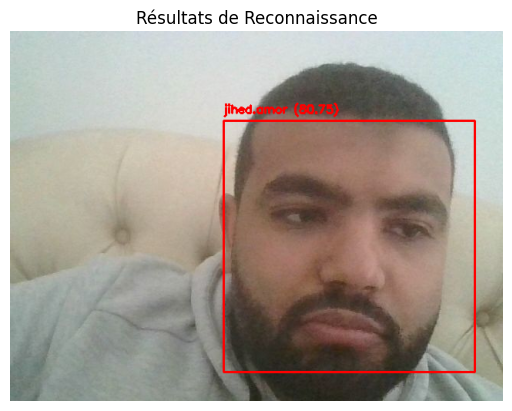


--------------------------------------- C'est vous -------------------------
Identifié comme: jihed.amor
*************************************** Acces autorisé ******************************

Détails:
- jihed.amor: Confiance 80.75 (Plus bas = meilleure correspondance)


In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Load face detection and recognition models
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
import cv2
face_recognizer = cv2.face.LBPHFaceRecognizer_create()

# Define paths
dataset_folder = "/content/drive/MyDrive/Colab Notebooks/Q1_TrainingData"
test_image_path = 'photo.jpg'  # Your newly captured photo

# Threshold for recognition confidence (lower is better)
RECOGNITION_THRESHOLD = 70  # Adjust based on your testing

# 1. Prepare Training Data
def prepare_training_data():
    faces = []
    labels = []
    label_ids = {}
    current_id = 0

    for root, dirs, files in os.walk(dataset_folder):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                path = os.path.join(root, file)
                label = os.path.basename(root)

                if label not in label_ids:
                    label_ids[label] = current_id
                    current_id += 1

                image = cv2.imread(path)
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                faces_detected = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

                for (x, y, w, h) in faces_detected:
                    faces.append(gray[y:y+h, x:x+w])
                    labels.append(label_ids[label])

    return faces, labels, label_ids

# 2. Train the Face Recognizer
faces, labels, label_ids = prepare_training_data()
face_recognizer.train(faces, np.array(labels))

# 3. Compare New Photo
def compare_faces(test_img_path):
    test_img = cv2.imread(test_img_path)
    if test_img is None:
        print("\n-------------------------------------- Image not found ---------------------------")
        return None

    gray_test = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
    faces_test = face_cascade.detectMultiScale(gray_test, scaleFactor=1.3, minNeighbors=5)

    if len(faces_test) == 0:
        print("\n-------------------------------------- Aucun visage détecté ---------------------------")
        return None

    results = []
    for (x, y, w, h) in faces_test:
        face_roi = gray_test[y:y+h, x:x+w]
        face_roi = cv2.resize(face_roi, (100, 100))

        label, confidence = face_recognizer.predict(face_roi)
        label_name = [k for k, v in label_ids.items() if v == label][0]
        results.append((label_name, confidence))

        # Draw rectangle and label
        color = (0, 255, 0) if confidence < RECOGNITION_THRESHOLD else (0, 0, 255)
        cv2.rectangle(test_img, (x, y), (x+w, y+h), color, 2)
        cv2.putText(test_img, f"{label_name} ({confidence:.2f})",
                   (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Display results
    plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Résultats de Reconnaissance")
    plt.show()

    return results

# 4. Run Comparison and Print Access Message
if len(os.listdir(dataset_folder)) < 2:
    print("Le dataset doit contenir au moins 2 images de personnes différentes")
else:
    comparison_results = compare_faces(test_image_path)

    if comparison_results:
        best_match = min(comparison_results, key=lambda x: x[1])  # Get result with lowest confidence score

        if best_match[1] > RECOGNITION_THRESHOLD:
            print("\n--------------------------------------- C'est vous -------------------------")
            print(f"Identifié comme: {best_match[0]}")
            print("*************************************** Acces autorisé ******************************")
        else:
            print("\n--------------------------------------- Ce n'est pas vous -------------------------")
            print("*************************************** Acces non autorisé ******************************")

        print(f"\nDétails:")
        for name, confidence in comparison_results:
            print(f"- {name}: Confiance {confidence:.2f} (Plus bas = meilleure correspondance)")